In [127]:
import cvxpy as cp
import numpy as np

# Risk functions module
#
# This module defines the financial risk measures to be used in the optimization layer of the E2E
# problem.
#


def p_var(z: cp.Expression, c: float, x: np.ndarray) -> cp.Expression:
    """
    Compute the squared error for the given input.

    :param z: A cvxpy expression (decision variable)
    :param c: A constant threshold or target value
    :param x: A numpy array (weights or features)
    :return: The squared error expression
    """
    return cp.square(x @ z - c)


def p_mad(z: cp.Expression, c: float, x: np.ndarray) -> cp.Expression:
    """
    Compute the mean absolute deviation for the given input.

    :param z: A cvxpy expression (decision variable)
    :param c: A constant threshold or target value
    :param x: A numpy array (weights or features)
    :return: The absolute deviation expression
    """
    return cp.abs(x @ z - c)


# Define test data
z = cp.Variable(3)  # Decision variable (portfolio weights)
c = 0.02  # Centering parameter (expected return)
x = np.array(
    [
        [0.05, 0.02, -0.01],  # Realized returns for multiple scenarios
        [0.03, -0.01, 0.04],
        [-0.02, 0.01, 0.01],
    ]
)
if __name__ == "__main__":

    # Test variance function (p_var)
    print("\nTesting p_var...")
    var_expr = p_var(z, c, x[0])  # Apply p_var to the first row of x
    objective_var = cp.Minimize(var_expr)  # Minimize the variance
    constraints = [
        cp.sum(z) == 1,
        z >= 0,
    ]  # Portfolio constraints: sum of weights = 1, weights >= 0
    problem_var = cp.Problem(objective_var, constraints)
    var_opt_value = problem_var.solve()

    # Output results for variance minimization
    print("Optimized portfolio weights (Variance):", z.value)
    print("Variance objective value:", var_opt_value)

    # Reinitialize decision variable for MAD problem
    z = cp.Variable(3)

    # Test MAD function (p_mad)
    print("\nTesting p_mad...")
    mad_expr = p_mad(z, c, x[0])  # Apply p_mad to the first row of x
    objective_mad = cp.Minimize(mad_expr)  # Minimize the MAD
    problem_mad = cp.Problem(objective_mad, constraints)
    mad_opt_value = problem_mad.solve()

    # Output results for MAD minimization
    print("Optimized portfolio weights (MAD):", z.value)
    print("MAD objective value:", mad_opt_value)



Testing p_var...
Optimized portfolio weights (Variance): [0.33333333 0.33333333 0.33333333]
Variance objective value: 0.0

Testing p_mad...
Optimized portfolio weights (MAD): [ 0.13355262  0.33328474 -0.66566742]
MAD objective value: 3.469446951953614e-18


In [128]:
import torch
from torch import Tensor


# Performance loss functions with type hints and improved comments
def single_period_loss(z_star: Tensor, y_perf: Tensor) -> Tensor:
    """
    Calculate the single-period loss based on the out-of-sample portfolio return.

    This function computes the out-of-sample portfolio return for a given portfolio over the next
    time step. It computes the loss as the negative return since optimization typically focuses
    on minimizing the loss, and maximizing returns translates into minimizing negative returns.

    :param z_star: Tensor of shape (n_y, 1) representing the optimal portfolio weights.
    :param y_perf: Tensor of shape (perf_period, n_y) representing the realized returns.
    :return: A scalar tensor representing the realized return at the first time step (negative).
    """
    # Calculate the portfolio return for the first time step and negate it (since we want to minimize loss)
    return -y_perf[0] @ z_star


def single_period_over_var_loss(z_star: Tensor, y_perf: Tensor) -> Tensor:
    """
    Calculate the loss as the portfolio return divided by the portfolio's volatility.

    This function computes the portfolio return at the first time step and divides it by the
    realized volatility (standard deviation) of the portfolio returns over the performance period.
    This provides a return-over-risk measure, which is often used in portfolio analysis.

    :param z_star: Tensor of shape (n_y, 1) representing the optimal portfolio weights.
    :param y_perf: Tensor of shape (perf_period, n_y) representing the realized returns.
    :return: A scalar tensor representing the return over realized volatility (negative).
    """
    # Calculate the portfolio returns over the entire performance period
    portfolio_returns = y_perf @ z_star
    # Calculate the standard deviation (volatility) of the portfolio returns, adding epsilon for numerical stability
    volatility = torch.std(portfolio_returns, unbiased=True) + 1e-6
    # Calculate the return at the first time step and divide by the volatility, then negate for loss
    return -portfolio_returns[0] / volatility


def sharpe_loss(z_star: Tensor, y_perf: Tensor) -> Tensor:
    """
    Calculate the loss based on the Sharpe ratio over a performance period.

    This function computes a simplified Sharpe ratio, which is the ratio of the mean portfolio
    return to its standard deviation (volatility) over the performance period. The loss is defined
    as the negative Sharpe ratio to allow for minimization.

    :param z_star: Tensor of shape (n_y, 1) representing the optimal portfolio weights.
    :param y_perf: Tensor of shape (perf_period, n_y) representing the realized returns.
    :return: A scalar tensor representing the negative Sharpe ratio.
    """
    # Ensure both tensors are of the same dtype
    z_star = z_star.to(y_perf.dtype)
    # Calculate the portfolio returns over the entire performance period
    portfolio_returns = y_perf @ z_star
    # Calculate the mean return of the portfolio
    mean_return = torch.mean(portfolio_returns)
    # Calculate the standard deviation (volatility) of the portfolio returns, adding epsilon for numerical stability
    volatility = torch.std(portfolio_returns, unbiased=True) + 1e-6
    # Calculate the Sharpe ratio and negate it for loss
    return -mean_return / volatility


if __name__ == "__main__":
    # Example portfolio weights (3 assets)
    z_star = torch.tensor([0.3, 0.5, 0.2])
    # Realized returns for 3 assets over 3 periods
    y_perf = torch.tensor(
        [
            [0.01, 0.02, -0.01],
            [0.03, -0.01, 0.04],
            [0.02, 0.01, 0.01],
        ]
    )

    # Test the single-period loss function
    print("Testing single_period_loss...")
    loss_sp = single_period_loss(z_star, y_perf)
    print(f"Single period loss: {loss_sp.item()}")

    # Test the single-period-over-volatility loss function
    print("\nTesting single_period_over_var_loss...")
    loss_sp_var = single_period_over_var_loss(z_star, y_perf)
    print(f"Single period loss over volatility: {loss_sp_var.item()}")

    # Test the Sharpe ratio loss function
    print("\nTesting sharpe_loss...")
    loss_sharpe = sharpe_loss(z_star, y_perf)
    print(f"Sharpe ratio loss: {loss_sharpe.item()}")

Testing single_period_loss...
Single period loss: -0.010999999940395355

Testing single_period_over_var_loss...
Single period loss over volatility: -10.989008903503418

Testing sharpe_loss...
Sharpe ratio loss: -11.988011360168457


In [129]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

####################################################################################################
# SlidingWindow Dataset to index data using a sliding window
####################################################################################################


class SlidingWindow(Dataset):
    """Dataset class for creating a sliding window from time series data."""

    def __init__(
        self,
        X: pd.DataFrame,
        Y: pd.DataFrame,
        n_obs: int,
        perf_period: int,
        dtype: torch.dtype = torch.float32,
        device: torch.device = torch.device("cpu"),
    ) -> None:
        """
        Initialize the SlidingWindow dataset.

        :param X: DataFrame containing the complete feature dataset.
        :param Y: DataFrame containing the complete asset return dataset.
        :param n_obs: Number of observations in the sliding window.
        :param perf_period: Number of future observations used for out-of-sample performance evaluation.
        :param dtype: The desired data type for tensors (default is torch.float32).
        :param device: Device on which to place the tensors (e.g., 'cpu' or 'cuda' for GPU).
        """
        self.X = torch.tensor(
            X.values, dtype=dtype, device=device
        )  # Convert feature dataset to tensor
        self.Y = torch.tensor(
            Y.values, dtype=dtype, device=device
        )  # Convert asset return dataset to tensor
        self.n_obs = n_obs  # Number of observations in the sliding window
        self.perf_period = (
            perf_period  # Number of future observations for performance evaluation
        )

    def __getitem__(
        self, index: int
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieve a single window of data.

        :param index: Index of the sliding window.
        :return: Tuple (x, y, y_perf):
            x: Features window of shape (n_obs + 1, n_x).
            y: Realizations window of shape (n_obs, n_y).
            y_perf: Future performance window of shape (perf_period, n_y).
        """
        # Retrieve features for the sliding window (n_obs + 1 observations)
        x = self.X[index : index + self.n_obs + 1]
        # Retrieve asset returns for the sliding window (n_obs observations)
        y = self.Y[index : index + self.n_obs]
        # Retrieve future performance data (perf_period observations)
        y_perf = self.Y[index + self.n_obs : index + self.n_obs + self.perf_period]
        return (x, y, y_perf)

    def __len__(self) -> int:
        """
        Return the number of windows that can be created from the dataset.

        :return: Length of the dataset, considering the sliding windows.
        """
        return (
            len(self.X) - self.n_obs - self.perf_period
        )  # Total number of sliding windows available


####################################################################################################
# Backtest class to store out-of-sample results
####################################################################################################


class Backtest:
    """Class to store out-of-sample results for a backtest."""

    def __init__(self, len_test: int, n_y: int, dates: pd.DatetimeIndex) -> None:
        """
        Initialize the Backtest object.

        :param len_test: Number of scenarios in the out-of-sample evaluation period.
        :param n_y: Number of assets in the portfolio.
        :param dates: DatetimeIndex containing the corresponding dates.
        """
        self.weights = np.zeros(
            (len_test, n_y)
        )  # Initialize portfolio weights over time
        self.rets = np.zeros(
            len_test
        )  # Initialize realized portfolio returns over time
        self.dates = dates[
            -len_test:
        ]  # Keep only the dates for the out-of-sample period

    def stats(self) -> None:
        """
        Compute and store the cumulative returns, mean return, volatility, and Sharpe ratio.

        This method calculates key performance metrics of the portfolio, including:
        - Cumulative returns (Total Return Index), which show the total growth of the portfolio over time.
        - Annualized mean return, which is an estimate of the average return the portfolio would achieve per year.
        - Volatility, which measures the risk by calculating the standard deviation of returns.
        - Sharpe ratio, which indicates the risk-adjusted return of the portfolio.
        """
        # Calculate cumulative returns (Total Return Index)
        tri = np.cumprod(self.rets + 1)
        # Calculate the annualized mean return using the final cumulative return and the number of periods
        self.mean = (tri[-1]) ** (1 / len(tri)) - 1
        # Calculate the volatility (standard deviation) of the portfolio returns
        self.vol = np.std(self.rets)
        # Calculate the Sharpe ratio (mean return divided by volatility)
        self.sharpe = self.mean / self.vol
        # Create a DataFrame containing realized returns and cumulative returns, indexed by dates
        if len(self.dates) == len(self.rets):
            self.rets = pd.DataFrame(
                {"Date": self.dates, "rets": self.rets, "tri": tri}
            ).set_index("Date")
        else:
            raise ValueError("Length of dates and returns must be equal.")


####################################################################################################
# InSample class to store in-sample results
####################################################################################################


class InSample:
    """Class to store the in-sample results of neural network training."""

    def __init__(self) -> None:
        """
        Initialize the InSample object.
        """
        self.loss = []  # List to hold training losses
        self.gamma = []  # List to hold gamma values (hyperparameter)
        self.delta = []  # List to hold delta values (hyperparameter)
        self.val_loss = []  # List to hold validation losses (optional)

    def df(self) -> pd.DataFrame:
        """
        Return a DataFrame containing the training statistics.

        :return: DataFrame with columns representing different metrics during training.
        """
        # Return a DataFrame based on available data, adjusting columns accordingly
        if not self.delta and not self.val_loss:
            return pd.DataFrame(
                list(zip(self.loss, self.gamma)), columns=["loss", "gamma"]
            )
        elif not self.delta:
            return pd.DataFrame(
                list(zip(self.loss, self.val_loss, self.gamma)),
                columns=["loss", "val_loss", "gamma"],
            )
        elif not self.val_loss:
            return pd.DataFrame(
                list(zip(self.loss, self.gamma, self.delta)),
                columns=["loss", "gamma", "delta"],
            )
        else:
            return pd.DataFrame(
                list(zip(self.loss, self.val_loss, self.gamma, self.delta)),
                columns=["loss", "val_loss", "gamma", "delta"],
            )


####################################################################################################
# CrossVal class to store cross-validation results
####################################################################################################


class CrossVal:
    """Class to store cross-validation results of neural network training."""

    def __init__(self) -> None:
        """
        Initialize the CrossVal object.
        """
        self.lr = []  # List to hold learning rates
        self.epochs = []  # List to hold the number of epochs in each run
        self.val_loss = []  # List to hold validation losses

    def df(self) -> pd.DataFrame:
        """
        Return a DataFrame containing the cross-validation statistics.

        :return: DataFrame with learning rate, epochs, and validation loss.
        """
        # Create and return a DataFrame with learning rates, epochs, and validation losses
        return pd.DataFrame(
            list(zip(self.lr, self.epochs, self.val_loss)),
            columns=["lr", "epochs", "val_loss"],
        )


####################################################################################################
# Test code for the Backtest class
####################################################################################################

if __name__ == "__main__":
    # Example usage
    X = pd.DataFrame(
        np.random.randn(100, 3)
    )  # Create feature dataset with 100 samples and 3 features
    Y = pd.DataFrame(
        np.random.randn(100, 2)
    )  # Create asset return dataset with 100 samples and 2 assets
    dates = pd.date_range(start="2020-01-01", periods=100, freq="D")

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize SlidingWindow with given parameters
    n_obs = 10
    perf_period = 5
    sliding_window = SlidingWindow(X, Y, n_obs, perf_period, device=device)

    # Fetch a sample window
    print("Testing SlidingWindow...")
    x, y, y_perf = sliding_window[0]
    print(f"x (features): {x.shape}")
    print(f"y (realizations): {y.shape}")
    print(f"y_perf (performance window): {y_perf.shape}")

    # Initialize Backtest with given parameters
    len_test = 30
    backtest_obj = Backtest(len_test=len_test, n_y=2, dates=dates)

    # Simulate some portfolio returns
    backtest_obj.rets = np.random.randn(len_test)

    print("\nTesting Backtest...")
    backtest_obj.stats()
    print(backtest_obj.rets.head())
    print(f"Mean return: {backtest_obj.mean:.4f}")
    print(f"Volatility: {backtest_obj.vol:.4f}")
    print(f"Sharpe ratio: {backtest_obj.sharpe:.4f}")

    # Test Backtest stats calculation
    print("\nTesting Backtest stats calculation...")
    backtest_obj.rets = np.array([0.05, -0.02, 0.03, 0.04, -0.01])
    backtest_obj.dates = dates[
        -len(backtest_obj.rets) :
    ]  # Adjust dates to match returns length
    backtest_obj.stats()
    print(backtest_obj.rets.head())
    print(f"Mean return: {backtest_obj.mean:.4f}")
    print(f"Volatility: {backtest_obj.vol:.4f}")
    print(f"Sharpe ratio: {backtest_obj.sharpe:.4f}")

Testing SlidingWindow...
x (features): torch.Size([11, 3])
y (realizations): torch.Size([10, 2])
y_perf (performance window): torch.Size([5, 2])

Testing Backtest...
                rets        tri
Date                           
2020-03-11  0.670167   1.670167
2020-03-12 -0.031396   1.617731
2020-03-13  1.908776   4.705617
2020-03-14  0.693825   7.970494
2020-03-15  0.628814  12.982450
Mean return: nan
Volatility: 0.9312
Sharpe ratio: nan

Testing Backtest stats calculation...
            rets       tri
Date                      
2020-04-05  0.05  1.050000
2020-04-06 -0.02  1.029000
2020-04-07  0.03  1.059870
2020-04-08  0.04  1.102265
2020-04-09 -0.01  1.091242
Mean return: 0.0176
Volatility: 0.0279
Sharpe ratio: 0.6324


C:\Users\23865\AppData\Local\Temp\ipykernel_34964\684581267.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.mean = (tri[-1]) ** (1 / len(tri)) - 1


In [130]:
# DataLoad module
#
####################################################################################################
# Import libraries
####################################################################################################
import torch
import torch.nn as nn
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import time
import statsmodels.api as sm


####################################################################################################
# TrainTest class
####################################################################################################
class TrainTest:
    def __init__(self, data: pd.DataFrame, n_obs: int, split: list[float]) -> None:
        """
        Object to hold the training, validation, and testing datasets.

        :param data: pandas DataFrame with time series data.
        :param n_obs: Number of observations per batch.
        :param split: List of ratios that control the partition of data into training, testing, and validation sets.
        """
        self.data: pd.DataFrame = data  # Store the input data as a DataFrame
        self.n_obs: int = n_obs  # Set the number of observations per batch
        self.split: list[float] = (
            split  # Set the split ratios for training, validation, and testing
        )

        n_obs_tot: int = self.data.shape[
            0
        ]  # Calculate the total number of observations in the dataset
        numel: np.ndarray = n_obs_tot * np.cumsum(
            split
        )  # Calculate the cumulative number of elements based on split ratios
        self.numel: list[int] = [
            round(i) for i in numel
        ]  # Round the cumulative elements to get the indices for splits

    def split_update(self, split: list[float]) -> None:
        """
        Update the list outlining the split ratio of training, validation, and testing datasets.

        :param split: List of ratios that control the partition of data into training, testing, and validation sets.
        """
        self.split: list[float] = (
            split  # Update the split ratios with the new list provided
        )
        n_obs_tot: int = self.data.shape[
            0
        ]  # Calculate the total number of observations in the dataset
        numel: np.ndarray = n_obs_tot * np.cumsum(
            split
        )  # Calculate the cumulative number of elements based on new split ratios
        self.numel: list[int] = [
            round(i) for i in numel
        ]  # Round the cumulative elements to get the indices for splits

    def train(self) -> pd.DataFrame:
        """
        Return the training subset of observations.

        :return: pandas DataFrame containing the training data subset.
        """
        return self.data[
            : self.numel[0]
        ]  # Return the data from the start up to the end of the training set

    def test(self) -> pd.DataFrame:
        """
        Return the test subset of observations.

        :return: pandas DataFrame containing the test data subset.
        """
        return self.data[
            self.numel[0] - self.n_obs : self.numel[1]
        ]  # Return the data for the test set, including overlap
if __name__ == "__main__":
    # Generate synthetic data for testing
    n_tot = 1000  # Total number of observations
    n_features = 5  # Number of features
    split_ratios = [0.7, 0.3]  # 70% training, 30% testing
    n_obs = 50  # Number of observations per batch

    # Create a synthetic DataFrame with random data
    data = pd.DataFrame(
        np.random.randn(n_tot, n_features),
        columns=[f"Feature_{i}" for i in range(n_features)],
    )

    # Initialize TrainTest object
    train_test_obj = TrainTest(data=data, n_obs=n_obs, split=split_ratios)

    # Test the training data split
    train_data = train_test_obj.train()
    print("Training Data:")
    print(train_data.head())
    print(f"Number of training observations: {len(train_data)}")

    # Test the test data split
    test_data = train_test_obj.test()
    print("\nTest Data:")
    print(test_data.head())
    print(f"Number of test observations: {len(test_data)}")

    # Update split ratios and test again
    new_split_ratios = [0.6, 0.4]  # Update split ratios
    train_test_obj.split_update(split=new_split_ratios)

    # Test the updated training data split
    updated_train_data = train_test_obj.train()
    print("\nUpdated Training Data:")
    print(updated_train_data.head())
    print(f"Number of updated training observations: {len(updated_train_data)}")

    # Test the updated test data split
    updated_test_data = train_test_obj.test()
    print("\nUpdated Test Data:")
    print(updated_test_data.head())
    print(f"Number of updated test observations: {len(updated_test_data)}")

Training Data:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4
0  -0.115457  -0.553431   0.889859   0.286378   1.765561
1  -0.247185  -0.122202   1.210383  -0.090921   1.494005
2   0.540828  -2.352786   1.177570   0.912727   0.951333
3  -1.910978  -0.662990  -0.588705  -0.841121   1.741923
4  -0.011768  -0.036561   0.552008   0.569302  -3.334893
Number of training observations: 700

Test Data:
     Feature_0  Feature_1  Feature_2  Feature_3  Feature_4
650  -1.194628   0.002823   0.578279   1.502827  -1.541358
651   0.975473   0.131153  -0.450667   0.759857  -0.235925
652   0.717531  -0.992270  -0.632997   0.943600   1.485401
653  -0.035032  -2.787289  -0.199049   0.032426  -0.232773
654   0.336339  -0.476910   0.838871  -1.166713   1.236849
Number of test observations: 350

Updated Training Data:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4
0  -0.115457  -0.553431   0.889859   0.286378   1.765561
1  -0.247185  -0.122202   1.210383  -0.090921   1.494005
2   0.540828

In [131]:
####################################################################################################
# Generate linear synthetic data
####################################################################################################
def synthetic(
    n_x: int = 5,
    n_y: int = 10,
    n_tot: int = 1200,
    n_obs: int = 104,
    split: list[float] = [0.6, 0.4],
    set_seed: int = 100,
) -> tuple[TrainTest, TrainTest]:
    """
    Generates synthetic (normally-distributed) asset and factor data.

    :param n_x: Number of features.
    :param n_y: Number of assets.
    :param n_tot: Number of observations in the whole dataset.
    :param n_obs: Number of observations per batch.
    :param split: List of floats representing train-validation-test split percentages (must sum up to one).
    :param set_seed: Integer seed for replicability of the numpy RNG.

    :return: Tuple of TrainTest objects for features and asset data split into train, validation, and test subsets.
    """
    np.random.seed(set_seed)  # Set the random seed for reproducibility

    # 'True' prediction bias and weights
    a: np.ndarray = (
        np.sort(np.random.rand(n_y) / 250) + 0.0001
    )  # Generate small bias terms for each asset
    b: np.ndarray = (
        np.random.randn(n_x, n_y) / 5
    )  # Generate random weights for linear relationships between features and assets
    c: np.ndarray = np.random.randn(
        int((n_x + 1) / 2), n_y
    )  # Generate additional random weights for auxiliary features

    # Noise standard deviation
    s: np.ndarray = (
        np.sort(np.random.rand(n_y)) / 20 + 0.02
    )  # Generate small standard deviations for noise for each asset

    # Synthetic features
    X: np.ndarray = (
        np.random.randn(n_tot, n_x) / 50
    )  # Generate synthetic features from a normal distribution
    X2: np.ndarray = (
        np.random.randn(n_tot, int((n_x + 1) / 2)) / 50
    )  # Generate auxiliary features from a normal distribution

    # Synthetic outputs
    Y: np.ndarray = (
        a + X @ b + X2 @ c + s * np.random.randn(n_tot, n_y)
    )  # Generate synthetic outputs based on linear combinations of features and noise

    X: pd.DataFrame = pd.DataFrame(X)  # Convert features to a pandas DataFrame
    Y: pd.DataFrame = pd.DataFrame(Y)  # Convert outputs to a pandas DataFrame

    # Partition dataset into training and testing sets
    return TrainTest(X, n_obs, split), TrainTest(
        Y, n_obs, split
    )  # Return TrainTest objects for features and outputs


####################################################################################################
# Test code for synthetic data generation
####################################################################################################
if __name__ == "__main__":
    # Parameters for synthetic data generation
    n_x = 5  # Number of features
    n_y = 10  # Number of assets
    n_tot = 1200  # Total number of observations
    n_obs = 104  # Number of observations per batch
    split = [0.6, 0.4]  # Split ratios for training and testing
    set_seed = 100  # Random seed for reproducibility

    # Generate synthetic data
    train_test_features, train_test_outputs = synthetic(
        n_x, n_y, n_tot, n_obs, split, set_seed
    )

    # Test the generated feature data
    train_features = train_test_features.train()
    test_features = train_test_features.test()
    print("Training Features:")
    print(train_features.head())
    print(f"Number of training feature observations: {len(train_features)}")
    print("\nTest Features:")
    print(test_features.head())
    print(f"Number of test feature observations: {len(test_features)}")

    # Test the generated output data
    train_outputs = train_test_outputs.train()
    test_outputs = train_test_outputs.test()
    print("\nTraining Outputs:")
    print(train_outputs.head())
    print(f"Number of training output observations: {len(train_outputs)}")
    print("\nTest Outputs:")
    print(test_outputs.head())
    print(f"Number of test output observations: {len(test_outputs)}")

    # Verify the shape of the generated data
    assert (
        train_features.shape[1] == n_x
    ), "Number of features in training set does not match expected value."
    assert (
        train_outputs.shape[1] == n_y
    ), "Number of assets in training set does not match expected value."
    assert (
        test_features.shape[1] == n_x
    ), "Number of features in test set does not match expected value."
    assert (
        test_outputs.shape[1] == n_y
    ), "Number of assets in test set does not match expected value."

Training Features:
          0         1         2         3         4
0  0.037531 -0.007538  0.036639  0.000060 -0.001520
1  0.000079 -0.003700 -0.049743 -0.034093 -0.022725
2 -0.059466  0.000666 -0.004978 -0.009004  0.002649
3  0.000444  0.006347 -0.015048 -0.025928  0.001903
4 -0.008474 -0.023720 -0.007309 -0.025420  0.031723
Number of training feature observations: 720

Test Features:
            0         1         2         3         4
616  0.014443  0.017019 -0.003300 -0.056563 -0.017051
617  0.018964 -0.016458 -0.003853 -0.011657 -0.022333
618 -0.022941  0.020247 -0.012068  0.003381  0.019936
619  0.006151  0.024943 -0.006490 -0.010648 -0.017412
620 -0.031169 -0.034504  0.012386  0.022285 -0.043454
Number of test feature observations: 584

Training Outputs:
          0         1         2         3         4         5         6  \
0  0.020391 -0.024384 -0.050628 -0.016314 -0.044117  0.017402  0.090213   
1 -0.001323  0.039438  0.068975 -0.035036  0.059205 -0.009392 -0.091626   

In [132]:
####################################################################################################
# Generate non-linear synthetic data
####################################################################################################
import numpy as np
import pandas as pd
import unittest


def synthetic_nl(
    n_x: int = 5,
    n_y: int = 10,
    n_tot: int = 1200,
    n_obs: int = 104,
    split: list[float] = [0.6, 0.4],
    set_seed: int = 100,
) -> tuple[TrainTest, TrainTest]:
    """
    Generates synthetic (normally-distributed) factor data and mixes them using a quadratic model
    of linear, squared, and cross products to produce the asset data.

    :param n_x: Number of features.
    :param n_y: Number of assets.
    :param n_tot: Number of observations in the whole dataset.
    :param n_obs: Number of observations per batch.
    :param split: List of floats representing train-validation-test split percentages (must sum up to one).
    :param set_seed: Integer seed for replicability of the numpy RNG.
    :return: Tuple of TrainTest objects for features and asset data split into train, validation, and test subsets.
    """
    # Set the random seed for reproducibility
    np.random.seed(set_seed)

    # Generate 'True' prediction bias and weights
    a: np.ndarray = (
        np.sort(np.random.rand(n_y) / 200) + 0.0005
    )  # Bias terms for each asset
    b: np.ndarray = np.random.randn(n_x, n_y) / 4  # Linear relationship weights
    c: np.ndarray = np.random.randn(
        int((n_x + 1) / 2), n_y
    )  # Auxiliary feature weights
    d: np.ndarray = np.random.randn(n_x**2, n_y) / n_x  # Cross-product weights

    # Generate noise standard deviation for each asset
    s: np.ndarray = np.sort(np.random.rand(n_y)) / 20 + 0.02

    # Generate synthetic features
    X: np.ndarray = np.random.randn(n_tot, n_x) / 50  # Main features
    X2: np.ndarray = (
        np.random.randn(n_tot, int((n_x + 1) / 2)) / 50
    )  # Auxiliary features
    X_cross: np.ndarray = 100 * (X[:, :, None] * X[:, None, :]).reshape(
        n_tot, n_x**2
    )  # Cross-product features
    X_cross = X_cross - X_cross.mean(axis=0)  # Center cross-product features

    # Generate synthetic outputs
    Y: np.ndarray = a + X @ b + X2 @ c + X_cross @ d + s * np.random.randn(n_tot, n_y)

    # Convert features and outputs to pandas DataFrames
    X_df: pd.DataFrame = pd.DataFrame(X)
    Y_df: pd.DataFrame = pd.DataFrame(Y)

    # Partition dataset into training and testing sets
    return TrainTest(X_df, n_obs, split), TrainTest(Y_df, n_obs, split)


####################################################################################################
# Unit Test for synthetic_nl function
####################################################################################################
def test_synthetic_nl() -> None:
    n_x = 5
    n_y = 10
    n_tot = 1200
    n_obs = 104
    split = [0.6, 0.4]
    set_seed = 100

    features, outputs = synthetic_nl(
        n_x=n_x,
        n_y=n_y,
        n_tot=n_tot,
        n_obs=n_obs,
        split=split,
        set_seed=set_seed,
    )

    assert isinstance(
        features, TrainTest
    ), "Features should be an instance of TrainTest."
    assert isinstance(outputs, TrainTest), "Outputs should be an instance of TrainTest."
    assert features.data.shape == (n_tot, n_x), "Features data shape mismatch."
    assert outputs.data.shape == (n_tot, n_y), "Outputs data shape mismatch."
    expected_train_len = int(n_tot * split[0])
    assert (
        len(features.train()) == expected_train_len
    ), "Training split size mismatch for features."
    assert (
        len(outputs.train()) == expected_train_len
    ), "Training split size mismatch for outputs."

    # Test reproducibility
    features_1, outputs_1 = synthetic_nl(
        n_x=n_x,
        n_y=n_y,
        n_tot=n_tot,
        n_obs=n_obs,
        split=split,
        set_seed=set_seed,
    )
    features_2, outputs_2 = synthetic_nl(
        n_x=n_x,
        n_y=n_y,
        n_tot=n_tot,
        n_obs=n_obs,
        split=split,
        set_seed=set_seed,
    )
    pd.testing.assert_frame_equal(
        features_1.data, features_2.data, "Feature data mismatch for reproducibility."
    )
    pd.testing.assert_frame_equal(
        outputs_1.data, outputs_2.data, "Output data mismatch for reproducibility."
    )


if __name__ == "__main__":
    test_synthetic_nl()
    print("All tests passed.")

All tests passed.


In [133]:
####################################################################################################
# Generate non-linear synthetic data
####################################################################################################
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from typing import List, Tuple, Optional
import time
import statsmodels.api as sm
import pandas_datareader as pdr
from alpha_vantage.timeseries import TimeSeries


# Function to generate synthetic data using a 3-layer neural network
def synthetic_NN(
    n_x: int = 5,
    n_y: int = 10,
    n_tot: int = 1200,
    n_obs: int = 104,
    split: List[float] = [0.6, 0.4],
    set_seed: int = 45678,
) -> Tuple["TrainTest", "TrainTest"]:
    """
    Generates synthetic (normally-distributed) factor data and mixes them using a 3-layer neural network.

    :param n_x: Number of features.
    :param n_y: Number of assets.
    :param n_tot: Number of observations in the whole dataset.
    :param n_obs: Number of observations per batch.
    :param split: List of floats representing train-validation-test split percentages (must sum up to one).
    :param set_seed: Integer seed for reproducibility.
    :return: Tuple of TrainTest objects for feature and asset data.
    """
    np.random.seed(set_seed)  # Set random seed for reproducibility

    # Generate synthetic features (n_tot samples with n_x features each)
    X: np.ndarray = (
        np.random.randn(n_tot, n_x) * 10 + 0.5
    )  # Scale and shift features to have varied range

    # Initialize neural network
    synth: synthetic3layer = synthetic3layer(
        n_x, n_y, set_seed
    ).double()  # Create an instance of the 3-layer neural network

    # Generate synthetic outputs using the neural network
    Y: torch.Tensor = synth(
        torch.from_numpy(X)
    )  # Convert X to a torch tensor and pass it through the neural network

    # Convert synthetic features and outputs to pandas DataFrames
    X_df: pd.DataFrame = pd.DataFrame(X)  # Convert features to DataFrame
    Y_df: pd.DataFrame = (
        pd.DataFrame(Y.detach().numpy()) / 10
    )  # Convert outputs to DataFrame and scale down

    # Return TrainTest objects for features and outputs
    return TrainTest(X_df, n_obs, split), TrainTest(Y_df, n_obs, split)


####################################################################################################
# Neural Network Module
####################################################################################################
class synthetic3layer(nn.Module):
    def __init__(self, n_x: int, n_y: int, set_seed: int) -> None:
        """
        Initialize a 3-layer neural network to synthesize data.

        :param n_x: Number of input features.
        :param n_y: Number of output features.
        :param set_seed: Integer seed for reproducibility.
        """
        super().__init__()  # Call the parent class (nn.Module) initializer
        torch.manual_seed(
            set_seed
        )  # Set random seed for torch to ensure reproducible weights

        # Define a neural network with 3 hidden layers
        self.pred_layer: nn.Sequential = nn.Sequential(
            nn.Linear(
                n_x, int(0.5 * (n_x + n_y))
            ),  # First linear layer to project input features to an intermediate size
            nn.ReLU(),  # ReLU activation function to introduce non-linearity
            nn.Linear(
                int(0.5 * (n_x + n_y)), int(0.6 * (n_x + n_y))
            ),  # Second linear layer to another intermediate size
            nn.ReLU(),  # ReLU activation function
            nn.Linear(
                int(0.6 * (n_x + n_y)), n_y
            ),  # Third linear layer to project to output size
            nn.ReLU(),  # ReLU activation function
            nn.Linear(n_y, n_y),  # Final linear layer to produce the final outputs
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass of the neural network to generate synthetic outputs.

        :param X: Features. (n_obs x n_x) torch tensor with feature time series data.
        :return: Synthetically generated output. (n_obs x n_y) torch tensor of outputs.
        """
        # Apply the prediction layer to each input tensor in the batch and stack the results
        return torch.stack([self.pred_layer(x_t) for x_t in X])


####################################################################################################
# Test code to detect bugs
####################################################################################################
def test_synthetic_nn() -> None:
    try:
        # Define parameters for the test
        n_x = 5
        n_y = 10
        n_tot = 1200
        n_obs = 104
        split = [0.6, 0.4]
        set_seed = 45678

        # Generate synthetic data
        features, outputs = synthetic_NN(n_x, n_y, n_tot, n_obs, split, set_seed)

        # Check if generated features and outputs are pandas DataFrames
        assert isinstance(
            features.data, pd.DataFrame
        ), "Features should be a pandas DataFrame."
        assert isinstance(
            outputs.data, pd.DataFrame
        ), "Outputs should be a pandas DataFrame."

        # Check the dimensions of the generated data
        assert features.data.shape == (
            n_tot,
            n_x,
        ), f"Expected features shape {(n_tot, n_x)}, but got {features.data.shape}."
        assert outputs.data.shape == (
            n_tot,
            n_y,
        ), f"Expected outputs shape {(n_tot, n_y)}, but got {outputs.data.shape}."

        # Check reproducibility
        features_1, outputs_1 = synthetic_NN(n_x, n_y, n_tot, n_obs, split, set_seed)
        features_2, outputs_2 = synthetic_NN(n_x, n_y, n_tot, n_obs, split, set_seed)
        pd.testing.assert_frame_equal(
            features_1.data,
            features_2.data,
            "Feature data mismatch for reproducibility.",
        )
        pd.testing.assert_frame_equal(
            outputs_1.data, outputs_2.data, "Output data mismatch for reproducibility."
        )

        print("All tests passed successfully.")
    except AssertionError as e:
        print(f"Test failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Run the test function
if __name__ == "__main__":
    test_synthetic_nn()

All tests passed successfully.


In [134]:
from typing import Callable
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

#---------------------------------------------------------------------------------------------------
# base_mod: CvxpyLayer that declares the portfolio optimization problem
#---------------------------------------------------------------------------------------------------
def base_mod(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    Base optimization problem declared as a CvxpyLayer object.

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable((n_y, 1), nonneg=True)  # Portfolio weights (long-only positions)

    # Parameters
    y_hat: cp.Parameter = cp.Parameter(n_y)  # Predicted outcomes (e.g., expected returns)
    
    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1  # Budget constraint: sum of weights equals 1
    ]

    # Objective function
    objective: cp.Minimize = cp.Minimize(-y_hat @ z)  # Maximize returns by minimizing negative expected returns

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(objective, constraints)

    return CvxpyLayer(problem, parameters=[y_hat], variables=[z])

#---------------------------------------------------------------------------------------------------
# nominal: CvxpyLayer that declares the nominal portfolio optimization problem
#---------------------------------------------------------------------------------------------------
def nominal(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    Nominal optimization problem declared as a CvxpyLayer object.

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable((n_y, 1), nonneg=True)  # Portfolio weights (long-only positions)
    c_aux: cp.Variable = cp.Variable()  # Auxiliary variable for risk calculation
    obj_aux: cp.Variable = cp.Variable(n_obs)  # Objective auxiliary variable for each scenario
    mu_aux: cp.Variable = cp.Variable()  # Expected portfolio return

    # Parameters
    ep: cp.Parameter = cp.Parameter((n_obs, n_y))  # Scenario matrix of residuals
    y_hat: cp.Parameter = cp.Parameter(n_y)  # Predicted outcomes (e.g., expected returns)
    gamma: cp.Parameter = cp.Parameter(nonneg=True)  # Risk aversion coefficient
    
    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1,  # Budget constraint: sum of weights equals 1
        mu_aux == y_hat @ z  # Calculate expected return
    ]
    for i in range(n_obs):
        constraints.append(obj_aux[i] >= prisk(z, c_aux, ep[i]))  # Add risk constraints for each scenario

    # Objective function
    objective: cp.Minimize = cp.Minimize((1 / n_obs) * cp.sum(obj_aux) - gamma * mu_aux)  # Minimize risk-adjusted return

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(objective, constraints)

    return CvxpyLayer(problem, parameters=[ep, y_hat, gamma], variables=[z])

In [135]:
import pandas as pd
import time
from alpha_vantage.timeseries import TimeSeries
import pandas_datareader.data as pdr

####################################################################################################
# Option 4: Factors from Kenneth French's data library and asset data from AlphaVantage
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
# https://www.alphavantage.co
####################################################################################################


def AV(
    start: str,
    end: str,
    split: list[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: int | None = None,
    use_cache: bool = False,
    save_results: bool = False,
    AV_key: str | None = "YDNA9HH8P2IW985M",
) -> tuple[TrainTest, TrainTest]:
    """
    Load data from Kenneth French's data library and from AlphaVantage.

    :param start: Start date of time series.
    :param end: End date of time series.
    :param split: List of floats representing train-validation-test split percentages.
    :param freq: Data frequency (daily, weekly, monthly). Default is 'weekly'.
    :param n_obs: Number of observations per batch. Default is 104.
    :param n_y: Number of features to select. If None, the maximum number (8) is used. Default is None.
    :param use_cache: Whether to load cached data or download new data. Default is False.
    :param save_results: Whether to save the data for future use. Default is False.
    :param AV_key: AlphaVantage API key for accessing their data. Default is 'YDNA9HH8P2IW985M'.
    :return: Tuple containing TrainTest objects for features and asset data.
    """
    if use_cache:
        # Load cached data
        X: pd.DataFrame = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y: pd.DataFrame = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define list of tickers to be downloaded
        tick_list: list[str] = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        # Select the first n_y tickers if specified
        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Ensure API key is provided
        if AV_key is None:
            print(
                """A personal AlphaVantage API key is required to load the asset pricing data.
                If you do not have a key, you can get one from www.alphavantage.co (free for academic users)"""
            )
            AV_key = input("Enter your AlphaVantage API key: ")

        # Initialize TimeSeries object to interact with AlphaVantage API
        ts: TimeSeries = TimeSeries(
            key=AV_key, output_format="pandas", indexing_type="date"
        )

        # Download asset data from AlphaVantage
        Y_list: list[pd.Series] = []
        for tick in tick_list:
            data, _ = ts.get_daily_adjusted(symbol=tick, outputsize="full")
            data = data["5. adjusted close"]
            Y_list.append(data)
            time.sleep(12.5)  # AlphaVantage rate limit to avoid API ban
        Y: pd.DataFrame = pd.concat(Y_list, axis=1)
        Y = Y[::-1]
        Y = Y.loc["1999-01-01":end].pct_change()
        Y = Y.loc[start:end]
        Y.columns = tick_list

        # Download factor data from Kenneth French's library
        dl_freq: str = "_daily"
        X: pd.DataFrame = pdr.get_data_famafrench(
            f"F-F_Research_Data_5_Factors_2x3{dl_freq}", start=start, end=end
        )[0]
        rf_df: pd.Series = X["RF"]
        X = X.drop(["RF"], axis=1)
        mom_df: pd.DataFrame = pdr.get_data_famafrench(
            f"F-F_Momentum_Factor{dl_freq}", start=start, end=end
        )[0]
        st_df: pd.DataFrame = pdr.get_data_famafrench(
            f"F-F_ST_Reversal_Factor{dl_freq}", start=start, end=end
        )[0]
        lt_df: pd.DataFrame = pdr.get_data_famafrench(
            f"F-F_LT_Reversal_Factor{dl_freq}", start=start, end=end
        )[0]

        # Concatenate all factors into a single DataFrame
        X = pd.concat([X, mom_df, st_df, lt_df], axis=1) / 100

        # Convert daily returns to weekly returns if specified
        if freq in ["weekly", "_weekly"]:
            Y = Y.resample("W-FRI").agg(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").agg(lambda x: (x + 1).prod() - 1)

        # Save the data if requested
        if save_results:
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")

    # Partition dataset into training and testing sets. Lag the data by one observation
    return TrainTest(X[:-1], n_obs, split), TrainTest(Y[1:], n_obs, split)


####################################################################################################
# Test code to verify functionality and detect bugs
####################################################################################################
def test_AV() -> None:
    """
    Test the AV function to ensure correctness of generated data.

    :return: None
    """
    try:
        # Define parameters for the test
        start = "2020-01-01"
        end = "2023-01-01"
        split = [0.7, 0.3]
        freq = "weekly"
        n_obs = 104
        n_y = 5
        use_cache = False
        save_results = False
        AV_key = "YDNA9HH8P2IW985M"

        # Generate synthetic data
        features, outputs = AV(
            start, end, split, freq, n_obs, n_y, use_cache, save_results, AV_key
        )

        # Check if generated features and outputs are pandas DataFrames
        assert isinstance(
            features.data, pd.DataFrame
        ), "Features should be a pandas DataFrame."
        assert isinstance(
            outputs.data, pd.DataFrame
        ), "Outputs should be a pandas DataFrame."

        # Check the dimensions of the generated data
        assert (
            features.data.shape[0] == outputs.data.shape[0]
        ), "Features and outputs should have matching number of rows."

        print("All tests passed successfully.")
    except AssertionError as e:
        print(f"Test failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Run the test function
if __name__ == "__main__":
    test_AV()

An unexpected error occurred: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints


In [136]:
import pandas as pd
import statsmodels.api as sm
import numpy as np


####################################################################################################
# Statistical Analysis Function
####################################################################################################
def statanalysis(X: pd.DataFrame, Y: pd.DataFrame) -> pd.DataFrame:
    """
    Conduct a pairwise statistical significance analysis of each feature in X against each asset in Y.

    :param X: DataFrame containing the time series of features (independent variables).
    :param Y: DataFrame containing the time series of asset returns (dependent variables).
    :return: DataFrame containing p-values obtained from regressing each individual feature against each individual asset.
    """
    # Initialize an empty DataFrame to store p-values
    stats: pd.DataFrame = pd.DataFrame(columns=X.columns, index=Y.columns)

    # Iterate over each asset (Y) and each feature (X) to perform OLS regression
    # OLS (Ordinary Least Squares) is used to estimate the relationship between each feature and asset return.
    # For each asset, regress it against each feature with a constant term to obtain the p-value.
    for ticker in Y.columns:
        for feature in X.columns:
            # Perform OLS regression and store the p-value of the feature
            stats.loc[ticker, feature] = (
                sm.OLS(Y[ticker].values, sm.add_constant(X[feature]).values)
                .fit()
                .pvalues[1]
            )

    # Convert p-values to float and round to two decimal places
    return stats.astype(float).round(2)


####################################################################################################
# Test code to verify functionality and avoid bugs
####################################################################################################
def test_statanalysis() -> None:
    """
    Test the statanalysis function to ensure it correctly calculates p-values for feature-asset relationships.

    :return: None
    """
    try:
        # Generate random data for testing
        np.random.seed(42)
        X_test = pd.DataFrame(
            np.random.randn(100, 5), columns=[f"Feature_{i+1}" for i in range(5)]
        )
        Y_test = pd.DataFrame(
            np.random.randn(100, 3), columns=[f"Asset_{i+1}" for i in range(3)]
        )

        # Run the statistical analysis
        stats_result = statanalysis(X_test, Y_test)

        # Check if the result is a DataFrame
        assert isinstance(
            stats_result, pd.DataFrame
        ), "The result should be a pandas DataFrame."

        # Check if the dimensions of the result match expectations
        assert stats_result.shape == (
            3,
            5,
        ), f"Expected shape (3, 5), but got {stats_result.shape}."

        # Check if all p-values are between 0 and 1
        assert (
            stats_result.map(lambda x: 0 <= x <= 1).all().all()
        ), "All p-values should be between 0 and 1."

        print("All tests passed successfully.")
    except AssertionError as e:
        print(f"Test failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Run the test function
if __name__ == "__main__":
    test_statanalysis()

All tests passed successfully.


In [137]:
import psutil

num_cores: int = (
    psutil.cpu_count()
)  # Get the number of CPU cores available in the system.
torch.set_num_threads(
    num_cores
)  # Set the number of threads for PyTorch to utilize all CPU cores.
if psutil.MACOS:
    num_cores = 0  # Set num_cores to 0 on macOS systems (specific behavior).

num_cores

16

In [138]:
from typing import Callable
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer


# ---------------------------------------------------------------------------------------------------
# base_mod: CvxpyLayer that declares the portfolio optimization problem
# ---------------------------------------------------------------------------------------------------
def base_mod(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    Base optimization problem declared as a CvxpyLayer object.

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable(
        (n_y, 1), nonneg=True
    )  # Portfolio weights (long-only positions)

    # Parameters
    y_hat: cp.Parameter = cp.Parameter(
        n_y
    )  # Predicted outcomes (e.g., expected returns)

    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1  # Budget constraint: sum of weights equals 1
    ]

    # Objective function
    objective: cp.Minimize = cp.Minimize(
        -y_hat @ z
    )  # Maximize returns by minimizing negative expected returns

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(objective, constraints)

    return CvxpyLayer(problem, parameters=[y_hat], variables=[z])


# ---------------------------------------------------------------------------------------------------
# nominal: CvxpyLayer that declares the nominal portfolio optimization problem
# ---------------------------------------------------------------------------------------------------
def nominal(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    Nominal optimization problem declared as a CvxpyLayer object.

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable(
        (n_y, 1), nonneg=True
    )  # Portfolio weights (long-only positions)
    c_aux: cp.Variable = cp.Variable()  # Auxiliary variable for risk calculation
    obj_aux: cp.Variable = cp.Variable(
        n_obs
    )  # Objective auxiliary variable for each scenario
    mu_aux: cp.Variable = cp.Variable()  # Expected portfolio return

    # Parameters
    ep: cp.Parameter = cp.Parameter((n_obs, n_y))  # Scenario matrix of residuals
    y_hat: cp.Parameter = cp.Parameter(
        n_y
    )  # Predicted outcomes (e.g., expected returns)
    gamma: cp.Parameter = cp.Parameter(nonneg=True)  # Risk aversion coefficient

    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1,  # Budget constraint: sum of weights equals 1
        mu_aux == y_hat @ z,  # Calculate expected return
    ]
    for i in range(n_obs):
        constraints.append(
            obj_aux[i] >= prisk(z, c_aux, ep[i])
        )  # Add risk constraints for each scenario

    # Objective function
    objective: cp.Minimize = cp.Minimize(
        (1 / n_obs) * cp.sum(obj_aux) - gamma * mu_aux
    )  # Minimize risk-adjusted return

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(objective, constraints)

    return CvxpyLayer(problem, parameters=[ep, y_hat, gamma], variables=[z])

In [139]:
# ---------------------------------------------------------------------------------------------------
# Total Variation: sum_t abs(p_t - q_t) <= delta
# ---------------------------------------------------------------------------------------------------
def tv(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    DRO layer using the 'Total Variation' distance to define the probability ambiguity set.
    From Ben-Tal et al. (2013).

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable(
        (n_y, 1), nonneg=True
    )  # Decision variable representing portfolio weights with nonnegative constraint.
    c_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable used in risk function calculation.
    lambda_aux: cp.Variable = cp.Variable(
        nonneg=True
    )  # Auxiliary variable representing Lagrange multiplier for the Total Variation constraint (nonnegative).
    eta_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable representing an additional term in the optimization.
    beta_aux: cp.Variable = cp.Variable(
        n_obs
    )  # Auxiliary variable representing scenario-specific values for optimization.
    mu_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable representing the expected return of the portfolio.

    # Parameters
    ep: cp.Parameter = cp.Parameter(
        (n_obs, n_y)
    )  # Parameter representing the different scenarios for asset returns.
    y_hat: cp.Parameter = cp.Parameter(
        n_y
    )  # Parameter representing the expected returns for each asset.
    gamma: cp.Parameter = cp.Parameter(
        nonneg=True
    )  # Parameter representing the risk-aversion coefficient (nonnegative).
    delta: cp.Parameter = cp.Parameter(
        nonneg=True
    )  # Parameter representing the size of the ambiguity set for Total Variation (nonnegative).

    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1,
        beta_aux >= -lambda_aux,
        mu_aux == y_hat @ z,
    ]  # Constraints for portfolio weights, auxiliary variables, and expected return.
    for i in range(n_obs):
        constraints.append(
            beta_aux[i] >= prisk(z, c_aux, ep[i]) - eta_aux
        )  # Constraint to enforce risk bounds for each scenario.
        constraints.append(
            lambda_aux >= prisk(z, c_aux, ep[i]) - eta_aux
        )  # Constraint for Lagrange multiplier to handle variation.

    # Objective function
    objective: cp.Minimize = cp.Minimize(
        eta_aux + delta * lambda_aux + (1 / n_obs) * cp.sum(beta_aux) - gamma * mu_aux
    )  # Objective to minimize the sum of risk terms and maximize expected return.

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(
        objective, constraints
    )  # Define the optimization problem with the objective and constraints.

    return CvxpyLayer(
        problem, parameters=[ep, y_hat, gamma, delta], variables=[z]
    )  # Return the CvxpyLayer that represents the optimization problem.


# ---------------------------------------------------------------------------------------------------
# Hellinger distance: sum_t (sqrt(p_t) - sqrt(q_t))^2 <= delta
# ---------------------------------------------------------------------------------------------------
def hellinger(n_y: int, n_obs: int, prisk: Callable) -> CvxpyLayer:
    """
    DRO layer using the Hellinger distance to define the probability ambiguity set.
    From Ben-Tal et al. (2013).

    :param n_y: Number of assets.
    :param n_obs: Number of scenarios in the dataset.
    :param prisk: Portfolio risk function.
    :return: CvxpyLayer representing the optimization layer.
    """
    # Variables
    z: cp.Variable = cp.Variable(
        (n_y, 1), nonneg=True
    )  # Decision variable representing portfolio weights with nonnegative constraint.
    c_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable used in risk function calculation.
    lambda_aux: cp.Variable = cp.Variable(
        nonneg=True
    )  # Auxiliary variable representing Lagrange multiplier for Hellinger constraint (nonnegative).
    xi_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable representing an additional term in the optimization.
    beta_aux: cp.Variable = cp.Variable(
        n_obs, nonneg=True
    )  # Scenario-specific auxiliary variable for optimization with nonnegative constraint.
    tau_aux: cp.Variable = cp.Variable(
        n_obs, nonneg=True
    )  # Auxiliary variable for scenario-specific terms, nonnegative.
    mu_aux: cp.Variable = (
        cp.Variable()
    )  # Auxiliary variable representing the expected return of the portfolio.

    # Parameters
    ep: cp.Parameter = cp.Parameter(
        (n_obs, n_y)
    )  # Parameter representing the different scenarios for asset returns.
    y_hat: cp.Parameter = cp.Parameter(
        n_y
    )  # Parameter representing the expected returns for each asset.
    gamma: cp.Parameter = cp.Parameter(
        nonneg=True
    )  # Parameter representing the risk-aversion coefficient (nonnegative).
    delta: cp.Parameter = cp.Parameter(
        nonneg=True
    )  # Parameter representing the size of the ambiguity set for Hellinger distance (nonnegative).

    # Constraints
    constraints: list[cp.Constraint] = [
        cp.sum(z) == 1,
        mu_aux == y_hat @ z,
    ]  # Constraints to ensure portfolio weights sum to 1 and compute expected return.
    for i in range(n_obs):
        constraints.append(
            xi_aux + lambda_aux >= prisk(z, c_aux, ep[i]) + tau_aux[i]
        )  # Constraint to handle Hellinger distance using auxiliary variables.
        constraints.append(
            beta_aux[i] >= cp.quad_over_lin(lambda_aux, tau_aux[i])
        )  # Quadratic constraint for scenario-specific optimization.

    # Objective function
    objective: cp.Minimize = cp.Minimize(
        xi_aux
        + (delta - 1) * lambda_aux
        + (1 / n_obs) * cp.sum(beta_aux)
        - gamma * mu_aux
    )  # Objective to minimize the sum of risk terms and maximize expected return.

    # Construct optimization problem and differentiable layer
    problem: cp.Problem = cp.Problem(
        objective, constraints
    )  # Define the optimization problem with the objective and constraints.

    return CvxpyLayer(
        problem, parameters=[ep, y_hat, gamma, delta], variables=[z]
    )  # Return the CvxpyLayer that represents the optimization problem.

if __name__ == "__main__":
    # Example usage of the base optimization problem
    base_layer: CvxpyLayer = base_mod(3, 10, p_var)
    y_hat: torch.Tensor = torch.randn(3)
    z_star: torch.Tensor = base_layer(y_hat)[0]
    print(f"Optimal portfolio weights (base): {z_star}")

    # Example usage of the nominal optimization problem
    nominal_layer: CvxpyLayer = nominal(3, 10, p_var)
    y_hat: torch.Tensor = torch.randn(3)
    ep: torch.Tensor = torch.randn(10, 3)
    gamma: torch.Tensor = torch.tensor(0.1)
    z_star: torch.Tensor = nominal_layer(ep, y_hat, gamma)[0]
    print(f"Optimal portfolio weights (nominal): {z_star}")

    # Example usage of the TV optimization problem
    tv_layer: CvxpyLayer = tv(3, 10, p_var)
    y_hat: torch.Tensor = torch.randn(3)
    ep: torch.Tensor = torch.randn(10, 3)
    gamma: torch.Tensor = torch.tensor(0.1)
    delta: torch.Tensor = torch.tensor(0.1)
    z_star: torch.Tensor = tv_layer(ep, y_hat, gamma, delta)[0]
    print(f"Optimal portfolio weights (TV): {z_star}")

    # Example usage of the Hellinger optimization problem
    hellinger_layer: CvxpyLayer = hellinger(3, 10, p_var)
    y_hat: torch.Tensor = torch.randn(3)
    ep: torch.Tensor = torch.randn(10, 3)
    gamma: torch.Tensor = torch.tensor(0.1)
    delta: torch.Tensor = torch.tensor(0.1)
    z_star: torch.Tensor = hellinger_layer(ep, y_hat, gamma, delta)[0]
    print(f"Optimal portfolio weights (Hellinger): {z_star}")

Optimal portfolio weights (base): tensor([[1.0001e-06],
        [3.1529e-06],
        [1.0000e+00]])
Optimal portfolio weights (nominal): tensor([[0.4170],
        [0.2629],
        [0.3202]])
Optimal portfolio weights (TV): tensor([[0.5549],
        [0.1979],
        [0.2472]])
Optimal portfolio weights (Hellinger): tensor([[0.3123],
        [0.4710],
        [0.2167]])


In [140]:
####################################################################################################
# Import libraries
####################################################################################################
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from collections.abc import Callable
import psutil

# Set the number of CPU cores for PyTorch
num_cores: int = psutil.cpu_count()
torch.set_num_threads(num_cores)
if psutil.MACOS:
    num_cores = 0

if __name__ == "__main__":
    print(f"Number of cores: {num_cores}")

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if __name__ == "__main__":
    print(f"Device: {device}")


####################################################################################################
# E2E neural network module
####################################################################################################
class e2e_net(nn.Module):
    """End-to-end DRO learning neural network module."""

    def __init__(
        self,
        n_x: int,
        n_y: int,
        n_obs: int,
        opt_layer: str = "nominal",
        prisk: str = "p_var",
        perf_loss: str = "sharpe_loss",
        pred_model: str = "linear",
        pred_loss_factor: float = 0.5,
        perf_period: int = 13,
        train_pred: bool = True,
        train_gamma: bool = True,
        train_delta: bool = True,
        set_seed: int | None = None,
        cache_path: str = "./cache/",
    ) -> None:
        """
        Initializes the End-to-End Learning Neural Net module.

        This module consists of a prediction layer ('pred_layer') and an optimization layer ('opt_layer').
        It supports different models such as linear, 2-layer, and 3-layer prediction models. Gamma and
        delta parameters can be learned during training.

        :param n_x: Number of input features
        :param n_y: Number of output assets
        :param n_obs: Number of scenarios
        :param opt_layer: Optimization layer to use ("nominal", "base_mod", "hellinger")
        :param prisk: Portfolio risk function used in the optimization layer
        :param perf_loss: Performance loss function
        :param pred_model: Type of prediction model ("linear", "2layer", "3layer")
        :param pred_loss_factor: Weight factor between prediction loss and performance loss
        :param perf_period: Number of lookahead periods used in 'perf_loss'
        :param train_pred: Boolean to allow training of the prediction layer
        :param train_gamma: Boolean to allow training of the 'gamma' parameter
        :param train_delta: Boolean to allow training of the 'delta' parameter
        :param set_seed: Optional int to set random seed for replicability
        :param cache_path: Path to store model data
        """
        super(e2e_net, self).__init__()

        # Set random seed for reproducibility
        if set_seed is not None:
            torch.manual_seed(set_seed)
            self.seed = set_seed

        self.n_x: int = n_x
        self.n_y: int = n_y
        self.n_obs: int = n_obs

        # Set prediction loss function if 'pred_loss_factor' is defined
        if pred_loss_factor is not None:
            self.pred_loss_factor = pred_loss_factor
            self.pred_loss = (
                torch.nn.MSELoss()
            )  # Mean Squared Error Loss for prediction
        else:
            self.pred_loss = None

        # Set performance loss function
        if perf_loss == "sharpe_loss":
            self.perf_loss = sharpe_loss
        elif perf_loss == "single_period_over_var_loss":
            self.perf_loss = single_period_over_var_loss
        elif perf_loss == "single_period_loss":
            self.perf_loss = single_period_loss
        else:
            raise Exception("Unsupported performance loss function.")

        # Number of lookahead steps for performance evaluation
        self.perf_period = perf_period

        # Initialize the gamma parameter (risk-return trade-off)
        self.gamma = nn.Parameter(torch.FloatTensor(1).uniform_(0.02, 0.1).to(device))
        self.gamma.requires_grad = train_gamma
        self.gamma_init = self.gamma.item()

        # Select the optimization model
        if opt_layer == "nominal":
            self.model_type = "nom"
        elif opt_layer == "base_mod":
            self.gamma.requires_grad = False  # 'gamma' not trainable in base model
            self.model_type = "base_mod"
        else:
            # Initialize delta parameter for DRO layer
            if opt_layer == "hellinger":
                ub = (1 - 1 / (n_obs**0.5)) / 2
                lb = (1 - 1 / (n_obs**0.5)) / 10
            else:
                ub = (1 - 1 / n_obs) / 2
                lb = (1 - 1 / n_obs) / 10
            self.delta = nn.Parameter(torch.FloatTensor(1).uniform_(lb, ub).to(device))
            self.delta.requires_grad = train_delta
            self.delta_init = self.delta.item()
            self.model_type = "dro"

        # LAYER: Prediction model
        self.pred_model = pred_model
        if pred_model == "linear":
            self.pred_layer = nn.Linear(n_x, n_y).to(device)  # Linear layer
            self.pred_layer.weight.requires_grad = train_pred
            self.pred_layer.bias.requires_grad = train_pred
        elif pred_model == "2layer":
            self.pred_layer = nn.Sequential(  # Two hidden layers
                nn.Linear(n_x, int(0.5 * (n_x + n_y))).to(device),
                nn.ReLU(),
                nn.Linear(int(0.5 * (n_x + n_y)), n_y).to(device),
                nn.ReLU(),
                nn.Linear(n_y, n_y).to(device),
            )
        elif pred_model == "3layer":
            self.pred_layer = nn.Sequential(  # Three hidden layers
                nn.Linear(n_x, int(0.5 * (n_x + n_y))).to(device),
                nn.ReLU(),
                nn.Linear(int(0.5 * (n_x + n_y)), int(0.6 * (n_x + n_y))).to(device),
                nn.ReLU(),
                nn.Linear(int(0.6 * (n_x + n_y)), n_y).to(device),
                nn.ReLU(),
                nn.Linear(n_y, n_y).to(device),
            )

        # LAYER: Optimization model using CvxpyLayer
        if prisk == "p_var":
            self.prisk = p_var
        elif prisk == "p_mad":
            self.prisk = p_mad
        else:
            raise Exception("Unsupported portfolio risk function.")

        if opt_layer == "nominal":
            self.opt_layer = nominal(n_y, n_obs, self.prisk).to(device)
        elif opt_layer == "base_mod":
            self.opt_layer = base_mod(n_y, n_obs, self.prisk).to(device)
        elif opt_layer == "hellinger":
            self.opt_layer = hellinger(n_y, n_obs, self.prisk).to(device)
        elif opt_layer == "tv":
            self.opt_layer = tv(n_y, n_obs, self.prisk).to(device)
        else:
            raise Exception("Unsupported optimization layer.")

        # Store the path for model data caching
        self.cache_path = cache_path
        self._save_initial_state(train_gamma, train_delta)

    def _save_initial_state(self, train_gamma: bool, train_delta: bool) -> None:
        """Stores the initial state of the model for reuse during training."""
        if train_gamma and train_delta:
            self.init_state_path = (
                f"{self.cache_path}{self.model_type}_initial_state_{self.pred_model}"
            )
        elif train_delta and not train_gamma:
            self.init_state_path = f"{self.cache_path}{self.model_type}_initial_state_{self.pred_model}_TrainGamma{train_gamma}"
        elif train_gamma and not train_delta:
            self.init_state_path = f"{self.cache_path}{self.model_type}_initial_state_{self.pred_model}_TrainDelta{train_delta}"
        else:
            self.init_state_path = f"{self.cache_path}{self.model_type}_initial_state_{self.pred_model}_TrainGamma{train_gamma}_TrainDelta{train_delta}"
        torch.save(self.state_dict(), self.init_state_path)

    ################################################################################################
    # forward: forward pass of the e2e neural net
    ################################################################################################
    def forward(
        self, X: torch.Tensor, Y: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the NN module.

        Passes inputs 'X' through the prediction layer to yield predictions 'Y_hat'. Residuals are
        calculated as 'ep = Y - Y_hat', and the residuals are passed to the optimization layer to
        find the optimal decision 'z_star'.

        :param X: Features (n_obs+1 x n_x) tensor of feature time series data
        :param Y: Realizations (n_obs x n_y) tensor of asset time series data
        :return: (y_hat, z_star) - Prediction and optimized decision vector (asset weights)
        """
        # Transfer tensors to GPU if available
        X = X.double().to(device)
        Y = Y.double().to(device)

        # Multiple predictions Y_hat from X
        Y_hat = torch.stack([self.pred_layer(x_t) for x_t in X]).double().to(device)

        # Calculate residuals
        ep = Y - Y_hat[:-1]  # (n_obs-1) x n_y
        y_hat = Y_hat[-1]  # Predicting the next period

        # Optimization solver arguments
        solver_args = {"solve_method": "ECOS", "max_iters": 120, "abstol": 1e-7}

        # Optimize z based on the model type
        if self.model_type == "nom":
            (z_star,) = self.opt_layer(ep, y_hat, self.gamma, solver_args=solver_args)
        elif self.model_type == "dro":
            (z_star,) = self.opt_layer(
                ep, y_hat, self.gamma, self.delta, solver_args=solver_args
            )
        elif self.model_type == "base_mod":
            (z_star,) = self.opt_layer(y_hat, solver_args=solver_args)

        return z_star.to(device), y_hat.to(device)

    ################################################################################################
    # net_train: Train the e2e neural net
    ################################################################################################
    def net_train(
        self,
        train_set: DataLoader,
        val_set: DataLoader | None = None,
        epochs: int | None = None,
        lr: float | None = None,
    ) -> float | None:
        """
        Train the neural net model.

        :param train_set: Training data (SlidingWindow object)
        :param val_set: Validation data (SlidingWindow object), optional
        :param epochs: Number of training epochs
        :param lr: Learning rate
        :return: Validation loss (optional)
        """
        # Set default epochs and learning rate if not provided
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        # Optimizer configuration
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        n_train = len(train_set)  # Number of training samples

        # Train the neural network
        for _ in range(epochs):
            train_loss: float = 0.0
            optimizer.zero_grad()

            for t, (x, y, y_perf) in enumerate(train_set):
                x: torch.Tensor = x.double().to(device)
                y: torch.Tensor = y.double().to(device)

                z_star, y_hat = self(x.squeeze(), y.squeeze())
                z_star: torch.Tensor = z_star.double()
                y_perf: torch.Tensor = y_perf.double()
                # Compute the loss
                if self.pred_loss is None:
                    loss = (1 / n_train) * self.perf_loss(
                        z_star, y_perf.squeeze().to(device)
                    )
                else:
                    loss = (1 / n_train) * (
                        self.perf_loss(z_star, y_perf.squeeze().to(device))
                        + (self.pred_loss_factor / self.n_y)
                        * self.pred_loss(y_hat, y_perf.squeeze()[0].to(device))
                    )

                # Backpropagate the loss
                loss.backward()
                train_loss += loss.item()

            optimizer.step()

            # Ensure gamma, delta are non-negative
            self._clamp_params()

        # Validate the model
        if val_set is not None:
            return self._validate_model(val_set)

    ################################################################################################
    # net_cv: Cross validation of the e2e neural net for hyperparameter tuning
    ################################################################################################
    def net_cv(self, X, Y, lr_list, epoch_list, n_val=4):
        """
        Cross-validation for the neural network.

        :param X: TrainTest object of feature timeseries data
        :param Y: TrainTest object of asset time series data
        :param lr_list: List of candidate learning rates
        :param epoch_list: List of candidate number of epochs
        :param n_val: Number of validation folds for cross-validation
        """
        results = CrossVal()
        X_temp = TrainTest(X.train(), X.n_obs, [1, 0])
        Y_temp = TrainTest(Y.train(), Y.n_obs, [1, 0])
        for epochs in epoch_list:
            for lr in lr_list:
                print(f"Training E2E {self.model_type} model: lr={lr}, epochs={epochs}")

                val_loss_tot = []
                for i in range(n_val - 1, -1, -1):

                    # Partition training dataset into training and validation subset
                    split = [round(1 - 0.2 * (i + 1), 2), 0.2]
                    X_temp.split_update(split)
                    Y_temp.split_update(split)

                    train_set = DataLoader(
                        SlidingWindow(
                            X_temp.train(), Y_temp.train(), self.n_obs, self.perf_period
                        )
                    )
                    val_set = DataLoader(
                        SlidingWindow(
                            X_temp.test(), Y_temp.test(), self.n_obs, self.perf_period
                        )
                    )

                    # Reset learnable parameters gamma and delta
                    self.load_state_dict(torch.load(self.init_state_path))

                    if self.pred_model == "linear":
                        X_train, Y_train = X_temp.train(), Y_temp.train()
                        X_train.insert(0, "ones", 1.0)

                        X_train = Variable(
                            torch.tensor(X_train.values, dtype=torch.double).to(device)
                        )
                        Y_train = Variable(
                            torch.tensor(Y_train.values, dtype=torch.double).to(device)
                        )

                        Theta = torch.inverse(X_train.T @ X_train) @ (
                            X_train.T @ Y_train
                        )
                        Theta = Theta.T
                        del X_train, Y_train

                        with torch.no_grad():
                            self.pred_layer.bias.copy_(Theta[:, 0])
                            self.pred_layer.weight.copy_(Theta[:, 1:])

                    val_loss = self.net_train(
                        train_set, val_set=val_set, lr=lr, epochs=epochs
                    )
                    val_loss_tot.append(val_loss)

                    print(f"Fold: {n_val-i} / {n_val}, val_loss: {val_loss}")

                # Store results
                results.val_loss.append(np.mean(val_loss_tot))
                results.lr.append(lr)
                results.epochs.append(epochs)

        # Convert results to dataframe
        self.cv_results = results.df()
        self.cv_results.to_pickle(self.init_state_path + "_results.pkl")

        # Select and store the optimal hyperparameters
        idx = self.cv_results.val_loss.idxmin()
        self.lr = self.cv_results.lr[idx]
        self.epochs = self.cv_results.epochs[idx]

        print(
            f"CV E2E {self.model_type} with hyperparameters: lr={self.lr}, epochs={self.epochs}"
        )

    ################################################################################################
    # net_roll_test: Rolling window out-of-sample test
    ################################################################################################
    def net_roll_test(self, X, Y, n_roll=4, lr=None, epochs=None):
        """Neural net rolling window out-of-sample test

        Inputs
        X: Features. ([n_obs+1] x n_x) torch tensor with feature timeseries data
        Y: Realizations. (n_obs x n_y) torch tensor with asset timeseries data
        n_roll: Number of training periods (i.e., number of times to retrain the model)
        lr: Learning rate for test. If 'None', the optimal learning rate is loaded
        epochs: Number of epochs for test. If 'None', the optimal # of epochs is loaded

        Output
        self.portfolio: add the backtest results to the e2e_net object
        """

        # Declare backtest object to hold the test results
        portfolio = Backtest(
            len(Y.test()) - Y.n_obs, self.n_y, Y.test().index[Y.n_obs :]
        )

        # Store trained gamma and delta values
        if self.model_type == "nom":
            self.gamma_trained = []
        elif self.model_type == "dro":
            self.gamma_trained = []
            self.delta_trained = []

        # Store the squared L2-norm of the prediction weights and their difference from OLS weights
        if self.pred_model == "linear":
            self.theta_L2 = []
            self.theta_dist_L2 = []

        # Store initial train/test split
        init_split = Y.split

        # Window size
        win_size = init_split[1] / n_roll

        split = [0, 0]
        t = 0
        for i in range(n_roll):

            print(f"Out-of-sample window: {i+1} / {n_roll}")

            split[0] = init_split[0] + win_size * i
            if i < n_roll - 1:
                split[1] = win_size
            else:
                split[1] = 1 - split[0]

            X.split_update(split), Y.split_update(split)
            train_set = DataLoader(
                SlidingWindow(X.train(), Y.train(), self.n_obs, self.perf_period)
            )
            test_set = DataLoader(SlidingWindow(X.test(), Y.test(), self.n_obs, 0))

            # Reset learnable parameters gamma and delta
            self.load_state_dict(torch.load(self.init_state_path))

            if self.pred_model == "linear":
                # Initialize the prediction layer weights to OLS regression weights
                X_train, Y_train = X.train(), Y.train()
                X_train.insert(0, "ones", 1.0)

                X_train = Variable(torch.tensor(X_train.values, dtype=torch.double))
                Y_train = Variable(torch.tensor(Y_train.values, dtype=torch.double))

                Theta = torch.inverse(X_train.T @ X_train) @ (X_train.T @ Y_train)
                Theta = Theta.T
                del X_train, Y_train

                with torch.no_grad():
                    self.pred_layer.bias.copy_(Theta[:, 0])
                    self.pred_layer.weight.copy_(Theta[:, 1:])

            # Train model using all available data preceding the test window
            self.net_train(train_set, lr=lr, epochs=epochs)

            # Store trained values of gamma and delta
            if self.model_type == "nom":
                self.gamma_trained.append(self.gamma.item())
            elif self.model_type == "dro":
                self.gamma_trained.append(self.gamma.item())
                self.delta_trained.append(self.delta.item())

            # Store the squared L2 norm of theta and distance between theta and OLS weights
            if self.pred_model == "linear":
                theta_L2 = torch.sum(self.pred_layer.weight**2, axis=()) + torch.sum(
                    self.pred_layer.bias**2, axis=()
                )
                theta_dist_L2 = torch.sum(
                    (self.pred_layer.weight - Theta[:, 1:]) ** 2, axis=()
                ) + torch.sum((self.pred_layer.bias - Theta[:, 0]) ** 2, axis=())
                self.theta_L2.append(theta_L2)
                self.theta_dist_L2.append(theta_dist_L2)

            # Test model
            with torch.no_grad():
                for j, (x, y, y_perf) in enumerate(test_set):

                    # Predict and optimize
                    x: torch.Tensor = x.double().to(device)
                    y: torch.Tensor = y.double().to(device)
                    z_star, _ = self(x.squeeze(), y.squeeze())

                    # Store portfolio weights and returns for each time step 't'
                    portfolio.weights[t] = z_star.squeeze().to("cpu")
                    portfolio.rets[t] = y_perf.squeeze() @ portfolio.weights[t]
                    t += 1

        # Reset dataset
        X, Y = X.split_update(init_split), Y.split_update(init_split)

        # Calculate the portfolio statistics using the realized portfolio returns
        portfolio.stats()

        self.portfolio = portfolio

    ################################################################################################
    # load_cv_results: Load cross validation results
    ################################################################################################
    def load_cv_results(self, cv_results):
        """
        Load cross validation results.

        :param cv_results: DataFrame containing cross-validation results
        """
        self.cv_results = cv_results
        idx = cv_results.val_loss.idxmin()
        self.lr = cv_results.lr[idx]
        self.epochs = cv_results.epochs[idx]

    ################################################################################################
    # Utility functions for clamping parameters and validation
    ################################################################################################
    def _clamp_params(self) -> None:
        """Clamps the gamma and delta parameters to ensure non-negativity."""
        for name, param in self.named_parameters():
            if name == "gamma":
                param.data.clamp_(0.0001)
            if name == "delta":
                param.data.clamp_(0.0001)

    def _validate_model(self, val_set: DataLoader) -> float:
        """
        Compute validation loss for the given validation set.

        :param val_set: DataLoader containing the validation set
        :return: Validation loss
        """
        n_val = len(val_set)
        val_loss = 0
        with torch.no_grad():
            for t, (x, y, y_perf) in enumerate(val_set):
                x: torch.Tensor = x.double().to(device)
                y: torch.Tensor = y.double().to(device)

                z_val, y_val = self(x.squeeze(), y.squeeze())
                z_val = z_val.double().to(device)
                y_perf = y_perf.double().to(device)

                if self.pred_loss is None:
                    loss = (1 / n_val) * self.perf_loss(
                        z_val, y_perf.squeeze().to(device)
                    )
                else:
                    loss = (1 / n_val) * (
                        self.perf_loss(z_val, y_perf.squeeze().to(device))
                        + (self.pred_loss_factor / self.n_y)
                        * self.pred_loss(y_val, y_perf.squeeze()[0].to(device))
                    )
                val_loss += loss.item()
        return val_loss

Number of cores: 16
Device: cuda


   Portfolio A  Portfolio B  Portfolio C
0         0.50         0.70         0.90
1         7.10         7.50         7.40
2         0.07         0.09         0.12
3         0.62         0.60         0.58


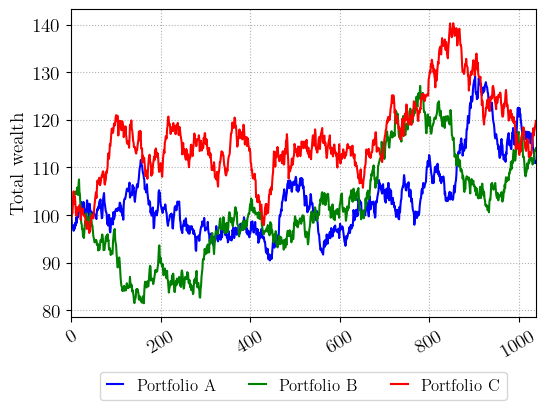

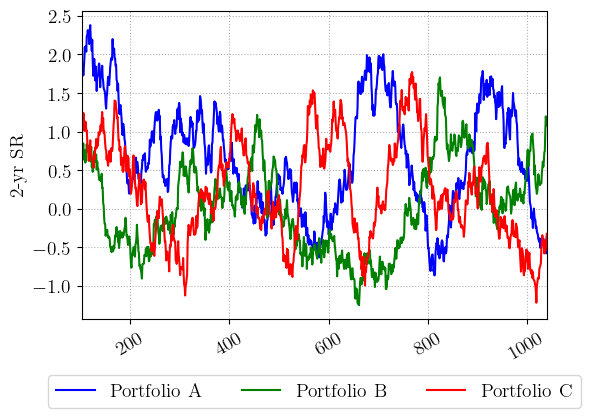

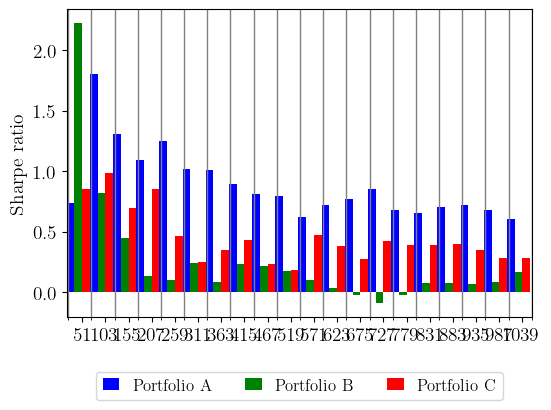

In [141]:
# PlotFunctions Module
#
####################################################################################################
## Import libraries
####################################################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from typing import List, Optional

# Matplotlib parameters
plt.close("all")
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["text.usetex"] = True

####################################################################################################
# Plotting functions
####################################################################################################


# ---------------------------------------------------------------------------------------------------
# wealth_plot function
# ---------------------------------------------------------------------------------------------------
def wealth_plot(
    portfolio_list: List,
    names: List[str],
    colors: List[str],
    nplots: int = 1,
    path: Optional[str] = None,
) -> None:
    """Plot of the portfolio wealth evolution over time (also known as the 'Total Return Index')

    :param portfolio_list: List of portfolio objects corresponding to the backtest of each model
    :param names: List of strings with the portfolio names that shall appear in the plot legend
    :param colors: List of strings with matplotlib color names to be used for each portfolio
    :param nplots: Number of subplots into which to distribute the results
    :param path: Path to which to save the image in pdf format. If 'None', then the image is not saved
    :return: None
    """
    n = len(portfolio_list)
    plot_df = pd.concat(
        [portfolio_list[i].rets.tri.rename(names[i]) * 100 for i in range(n)], axis=1
    )
    s = pd.DataFrame([100 * np.ones(n)], columns=names)
    if isinstance(plot_df.index, pd.DatetimeIndex):
        s.index = [plot_df.index[0] - pd.Timedelta(days=7)]
    else:
        s.index = [plot_df.index[0] - 1]
    plot_df = pd.concat([s, plot_df])

    if nplots == 1:
        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(n):
            ax.plot(plot_df[names[i]], color=colors[i])
        ax.legend(
            names,
            ncol=n,
            fontsize=12,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            handlelength=1,
        )
        ax.grid(visible=True, linestyle=":", linewidth=0.8)
        ax.tick_params(axis="x", labelrotation=30)
        plt.ylabel("Total wealth", fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    else:
        fig, ax = plt.subplots(figsize=(max([6, nplots * 4]), 4), ncols=nplots)
        for i in range(n):
            j = int(nplots / n * i)
            ax[j].plot(plot_df[names[i]], color=colors[i])
            if j == 0:
                ax[j].set_ylabel("Total wealth", fontsize=14)
            ax[j].tick_params(axis="both", which="major", labelsize=14)

        for j in range(nplots):
            i = int(j * n / nplots)
            k = int((j + 1) * n / nplots)
            ax[j].legend(
                names[i:k],
                ncol=int(n / nplots),
                fontsize=12,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.15),
                handlelength=1,
            )
            ax[j].grid(visible=True, linestyle=":", linewidth=0.8)
            ax[j].tick_params(axis="x", labelrotation=30)

    if path is not None:
        fig.savefig(path, bbox_inches="tight")
        fig.savefig(path[0:-3] + "ps", bbox_inches="tight", format="ps")


# ---------------------------------------------------------------------------------------------------
# sr_plot function
# ---------------------------------------------------------------------------------------------------
def sr_plot(
    portfolio_list: List,
    names: List[str],
    colors: List[str],
    path: Optional[str] = None,
) -> None:
    """Plot of the Sharpe ratio calculated over a rolling 2-year period

    :param portfolio_list: List of portfolio objects corresponding to the backtest of each model
    :param names: List of strings with the portfolio names that shall appear in the plot legend
    :param colors: List of strings with matplotlib color names to be used for each portfolio
    :param path: Path to save the plot image (optional)
    :return: None
    """
    time_period = 104
    df = pd.concat(
        [
            portfolio_list[i].rets.rets.rename(names[i])
            for i in range(len(portfolio_list))
        ],
        axis=1,
    )
    mean_df = ((df + 1).rolling(time_period).apply(gmean)) ** 52 - 1
    mean_df.dropna()
    std_df = df.rolling(time_period).std()
    std_df.dropna()
    plot_df = mean_df / (std_df * np.sqrt(52))

    fig, ax = plt.subplots(figsize=(6, 4))
    for i in range(len(portfolio_list)):
        ax.plot(plot_df[names[i]], color=colors[i])

    ax.legend(
        names, ncol=3, fontsize=14, loc="upper center", bbox_to_anchor=(0.5, -0.15)
    )
    ax.grid(visible=True, linestyle=":", linewidth=0.8)
    ax.tick_params(axis="x", labelrotation=30)
    plt.ylabel("2-yr SR", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if path is not None:
        fig.savefig(path, bbox_inches="tight")
        fig.savefig(path[0:-3] + "eps", bbox_inches="tight", format="eps")


# ---------------------------------------------------------------------------------------------------
# sr_bar function
# ---------------------------------------------------------------------------------------------------
def sr_bar(
    portfolio_list: List,
    names: List[str],
    colors: List[str],
    path: Optional[str] = None,
) -> None:
    """Bar plot of the Sharpe ratio calculated over a rolling 2-year period

    :param portfolio_list: List of portfolio objects corresponding to the backtest of each model
    :param names: List of strings with the portfolio names that shall appear in the plot legend
    :param colors: List of strings with matplotlib color names to be used for each portfolio
    :param path: Path to save the plot image (optional)
    :return: None
    """
    n = len(portfolio_list)
    df = pd.concat(
        [portfolio_list[i].rets.rets.rename(names[i]) for i in range(n)], axis=1
    )

    mean_df = df.expanding(min_periods=1).mean().groupby(df.index // 52).tail(1)
    std_df = df.expanding(min_periods=1).std().groupby(df.index // 52).tail(1)
    plot_df = mean_df / std_df * np.sqrt(52)

    x = np.arange(plot_df.shape[0])
    w = 1 / n
    fig, ax = plt.subplots(figsize=(6, 4))
    for i in range(n):
        ax.bar(x - 0.5 + i / n, plot_df[names[i]], w, color=colors[i])

    ax.legend(
        names,
        ncol=n,
        fontsize=12,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        handlelength=1,
    )
    ax.grid(visible=True, linestyle=":", linewidth=0.8)
    ax.set_xticks(x, labels=plot_df.index.astype(str).to_list())

    ax.set_xticks(np.arange(-0.6, plot_df.shape[0], 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle="-", linewidth=1)
    ax.grid(which="major", color="w", linestyle="-", linewidth=0)

    plt.ylabel("Sharpe ratio", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if path is not None:
        fig.savefig(path, bbox_inches="tight")
        fig.savefig(path[0:-3] + "eps", bbox_inches="tight", format="eps")


# ---------------------------------------------------------------------------------------------------
# learn_plot function
# ---------------------------------------------------------------------------------------------------
def learn_plot(
    trained_vals: pd.DataFrame,
    colors: List[str],
    marker: List[str],
    delta_mark: int,
    path: Optional[str] = None,
) -> None:
    """Plot of the learned parameters (gamma as bar, delta as line)

    :param trained_vals: DataFrame of learned parameters
    :param colors: List of strings with matplotlib color names to be used for each portfolio
    :param marker: List of marker styles for each parameter
    :param delta_mark: Index to mark the separation between gamma and delta parameters
    :param path: Path to save the plot image (optional)
    :return: None
    """
    t, n = trained_vals.shape
    x = np.linspace(0, t - 1, num=t)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax2 = ax.twinx()
    for i in range(n):
        if i < delta_mark:
            ax.stem(
                x + i / 5,
                trained_vals.iloc[:, i],
                linefmt=colors[i],
                markerfmt=marker[i],
                bottom=trained_vals.iloc[0, i],
            )
        else:
            ax2.stem(
                x + i / 5,
                trained_vals.iloc[:, i],
                linefmt=colors[i],
                markerfmt=marker[i],
                bottom=trained_vals.iloc[0, i],
            )

    ax.legend(
        trained_vals.columns,
        ncol=n,
        fontsize=12,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        handlelength=1,
    )
    ax.grid(b=True, linestyle=":", linewidth=0.8)

    ax.set_xlabel(r"Training period", fontsize=14)  # r is for raw string
    ax.set_ylabel(r"$\gamma$", fontsize=14)
    if n > delta_mark:
        ax2.set_ylabel(r"$\delta$", fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if path is not None:
        fig.savefig(path, bbox_inches="tight")
        fig.savefig(path[0:-3] + "eps", bbox_inches="tight", format="eps")


####################################################################################################
# Other results
####################################################################################################
# ---------------------------------------------------------------------------------------------------
# fin_table
# ---------------------------------------------------------------------------------------------------
def fin_table(portfolios: List, names: List[str]) -> pd.DataFrame:
    """Compute portfolio performance statistics and summarize them as a table

    :param portfolios: List of backtest-type objects
    :param names: List of strings with the portfolio names
    :return: DataFrame summarizing the portfolio performance statistics
    """
    rets = []
    vols = []
    SRs = []
    invHidxs = []

    for portfolio in portfolios:
        ret = (
            portfolio.rets.tri.iloc[-1] ** (1 / portfolio.rets.tri.shape[0])
        ) ** 52 - 1
        vol = portfolio.vol * np.sqrt(52)
        SR = ret / vol
        invHidx = round(
            1 / (pd.DataFrame(portfolio.weights) ** 2).sum(axis=1).mean(), ndigits=2
        )
        rets.append(round(ret * 100, ndigits=1))
        vols.append(round(vol * 100, ndigits=1))
        SRs.append(round(SR, ndigits=2))
        invHidxs.append(invHidx)

    table = pd.DataFrame(np.array([rets, vols, SRs, invHidxs]), columns=names)
    table.set_axis(
        ["Return (%)", "Volatility (%)", "Sharpe ratio", "Avg. inv. HHI"],
        axis=0,
    )

    return table


####################################################################################################
# Test functions
####################################################################################################
if __name__ == "__main__":
    # Test data (mock portfolio data)
    class MockPortfolio:
        def __init__(self):
            self.rets = pd.DataFrame(
                {
                    "rets": np.random.randn(1040)/100,
                    "tri": (1 + np.random.randn(1040) / 100).cumprod(),
                }
            )
            self.vol = np.std(self.rets["rets"])
            self.weights = np.random.rand(1040, 5)

    portfolios = [MockPortfolio() for _ in range(3)]
    names = ["Portfolio A", "Portfolio B", "Portfolio C"]
    colors = ["blue", "green", "red"]

    # Test wealth_plot
    wealth_plot(portfolios, names, colors)

    # Test sr_plot
    sr_plot(portfolios, names, colors)

    # Test sr_bar
    sr_bar(portfolios, names, colors)

    # Test fin_table
    table = fin_table(portfolios, names)
    print(table)

In [142]:
# Distributionally Robust End-to-End Portfolio Construction
# Experiment 1 - General
####################################################################################################
# Import libraries
####################################################################################################
import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

plt.close("all")

# Make the code device-agnostic
# device is a variable that determines whether to use GPU ('cuda') or CPU ('cpu') based on availability.
device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Path to cache the data, models, and results
# cache_path is the directory path used to store cached data, models, and results for future use.
cache_path: str = "./cache/exp/"

####################################################################################################
# Experiments 1-4 (with historical data): Load data
####################################################################################################

# Data frequency and start/end dates
# freq specifies the frequency of the data ('daily', 'weekly', etc.).
# start and end define the date range for loading the historical data.
freq: str = "weekly"
start: str = "2000-01-01"
end: str = "2021-09-30"

# Train, validation, and test split percentage
# split is a list containing the percentage split for training and validation data.
split: list[float] = [0.6, 0.4]

# Number of observations per window
# n_obs defines the number of historical observations considered in each rolling window.
n_obs: int = 104

# Number of assets
# n_y represents the number of assets included in the analysis.
n_y: int = 20

# AlphaVantage API Key
# AV_key is an API key used to access data from AlphaVantage. Users can obtain a key for free.
# If set to None, the program may use cached data instead of downloading new data.
AV_key: str | None = "YDNA9HH8P2IW985M"

# Historical data: Download data (or load cached data)
# X and Y represent the features and target variables, respectively, used for training.
# Data is downloaded or loaded from the cache, depending on the availability of cached data.
X, Y = AV(
    start=start,
    end=end,
    split=split,
    freq=freq,
    n_obs=n_obs,
    n_y=n_y,
    use_cache=True,
    save_results=False,
    AV_key=AV_key,
)

# Number of features and assets
# n_x and n_y represent the number of features and target assets, respectively.
n_x: int = X.data.shape[1]
n_y: int = Y.data.shape[1]

# Statistical significance analysis of features vs targets
# stats is a DataFrame containing the statistical significance analysis between features and target variables.
stats: pd.DataFrame = statanalysis(X.data, Y.data)
stats.head()

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev
AAPL,0.59,0.90,0.64,0.83,0.49,0.28,0.18,0.32
MSFT,0.27,0.41,0.84,0.98,0.25,0.22,0.42,0.35
AMZN,0.31,0.07,0.71,0.19,0.53,0.10,0.11,0.28
C,0.17,0.79,0.02,0.01,0.30,0.20,0.01,0.45
JPM,0.25,1.00,0.00,0.47,0.31,0.15,0.08,0.03


In [143]:
####################################################################################################
# E2E Learning System Run
####################################################################################################

import pickle


# ---------------------------------------------------------------------------------------------------
# Initialize parameters
# ---------------------------------------------------------------------------------------------------

# Loss function to optimize during training, here set to Sharpe ratio loss ('sharpe_loss').
perf_loss: str = "sharpe_loss"

# Performance evaluation period (e.g., next quarter), default is 13 weeks.
perf_period: int = 13

# Weight assigned to MSE prediction loss function in multi-objective training.
pred_loss_factor: float = 0.5

# Risk function used in the model, set to variance ('p_var').
prisk: str = "p_var"

# Distributionally Robust (DR) decision layer type to use: either Hellinger ('hellinger') or Total Variation ('tv').
dr_layer: str = "hellinger"

# List of learning rates to test during model training.
lr_list: list[float] = [0.005, 0.0125, 0.02]

# List of total epochs to train the models for during hyperparameter tuning.
epoch_list: list[int] = [30, 40, 50, 60, 80, 100]

# Random seed value for replicability of experiments.
set_seed: int = 1000

# Path to cache directory.
cache_path: str = "./cache/exp/"

# ---------------------------------------------------------------------------------------------------
# Run
# ---------------------------------------------------------------------------------------------------
if_cross_val: bool = False
if if_cross_val:
    full_dr_net = e2e_net(
        n_x,
        n_y,
        n_obs,
        prisk=prisk,
        train_pred=True,
        train_gamma=True,
        train_delta=True,
        set_seed=set_seed,
        opt_layer="hellinger",
        perf_loss=perf_loss,
        cache_path=cache_path,
        perf_period=perf_period,
        pred_loss_factor=pred_loss_factor,
        pred_model="3layer",
    ).double()
    full_dr_net.to(device)
    full_dr_net.net_cv(X, Y, lr_list, epoch_list)
    full_dr_net.net_roll_test(X, Y)
    with open(cache_path + "full_dr_net.pkl", "wb") as outp:
        pickle.dump(full_dr_net, outp, pickle.HIGHEST_PROTOCOL)
    print("Full DR net training and testing complete.")

In [144]:
lr_list: list[float] = [0.005]

# List of total epochs to train the models for during hyperparameter tuning.
epoch_list: list[int] = [1]

# Random seed value for replicability of experiments.
set_seed: int = 1000

# Path to cache directory.
cache_path: str = "./cache/exp/"

# ---------------------------------------------------------------------------------------------------
# Run the full DR net
# ---------------------------------------------------------------------------------------------------

full_dr_net = e2e_net(
    n_x,
    n_y,
    n_obs,
    prisk=prisk,
    train_pred=True,
    train_gamma=True,
    train_delta=True,
    set_seed=set_seed,
    opt_layer="hellinger",
    perf_loss=perf_loss,
    cache_path=cache_path,
    perf_period=perf_period,
    pred_loss_factor=pred_loss_factor,
    pred_model="3layer",
).double()
full_dr_net.to(device)
full_dr_net.net_cv(X, Y, lr_list, epoch_list)
full_dr_net.net_roll_test(X, Y)
with open(cache_path + "full_dr_net.pkl", "wb") as outp:
    pickle.dump(full_dr_net, outp, pickle.HIGHEST_PROTOCOL)
print("Full DR net training and testing complete.")

Training E2E dro model: lr=0.005, epochs=1


C:\Users\23865\AppData\Local\Temp\ipykernel_34964\508402949.py:342: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.init_state_path))


Fold: 1 / 4, val_loss: -0.22636206558799396
Fold: 2 / 4, val_loss: -0.09825838145289531
Fold: 3 / 4, val_loss: -0.07886846196969903
Fold: 4 / 4, val_loss: -0.2604965739417219
CV E2E dro with hyperparameters: lr=0.005, epochs=1
Out-of-sample window: 1 / 4


C:\Users\23865\AppData\Local\Temp\ipykernel_34964\508402949.py:449: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.init_state_path))
C:\U

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
# Sort the validation results of full DR net for analysis
full_dr_net.cv_results = full_dr_net.cv_results.sort_values(
    by=["epochs", "lr"], ascending=[True, True]
).reset_index(drop=True)

# Combine validation results from base, nominal, and full DR models into a single table
exp1_validation_table = pd.concat(
    (
        full_dr_net.cv_results["val_loss"].round(4),
    ),
    axis=1,
)
exp1_validation_table.columns = ["eta", "Epochs", "Base", "Nom.", "DR"]

# Set plot parameters
plt.rcParams["text.usetex"] = True
portfolio_names: list[str] = [r"EW", r"PO", r"Base", r"Nominal", r"DR"]
portfolios = [
    full_dr_net.portfolio,
]

# Generate the out-of-sample financial summary statistics table
exp1_fin_table = fin_table(portfolios, portfolio_names)

# Plot the wealth evolution of each portfolio over time
portfolio_colors: list[str] = [
    "dimgray",
    "forestgreen",
    "goldenrod",
    "dodgerblue",
    "salmon",
]
wealth_plot(
    portfolios,
    portfolio_names,
    portfolio_colors,
    path=cache_path + "plots/wealth_exp1.pdf",
)

# Plot the Sharpe ratio bar plot for each portfolio
sr_bar(
    portfolios,
    portfolio_names,
    portfolio_colors,
    path=cache_path + "plots/sr_bar_exp1.pdf",
)

# Store the initial parameter values for models
exp1_param_dict: dict[str, float | list[float]] = {
    "full_dr_net": [full_dr_net.gamma_init, full_dr_net.delta_init],
}

# Create a DataFrame to store trained values for each out-of-sample investment period
exp1_trained_vals = pd.DataFrame(
    {
        r"DR $\gamma$": [full_dr_net.gamma_init] + full_dr_net.gamma_trained,
        r"DR $\delta$": [full_dr_net.delta_init] + full_dr_net.delta_trained,
    }
)